In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sin, pi

from matplotlib import animation, rc
from IPython.display import HTML


# Helper function to draw animation
def plot_animated(x, y, x_noise=None, y_noise=None, x_pred=None, y_pred=None, interval=100, show_clean=True, pred_ahead=0):
    fig, ax = plt.subplots(figsize=(12, 8))
    x_pred_axis = None if x_pred is None else x_pred.flatten()
    y_pred_axis = None if y_pred is None else y_pred.flatten()
    x_concat = np.concatenate([list_x for list_x in [x, x_noise, x_pred_axis] if list_x is not None])
    y_concat = np.concatenate([list_y for list_y in [y, y_noise, y_pred_axis] if list_y is not None])
    _ = ax.set_xlim((min(x_concat), max(x_concat) * 1.1))
    _ = ax.set_ylim((min(y_concat), max(y_concat) * 1.1))
    plot_ball, = ax.plot([], [], "ob", markersize=8)
    plot_clean, = ax.plot([], [], "-y", markersize=1)
    plot_noise, = ax.plot([], [], "xb", markersize=5)
    plot_pred_ball, = ax.plot([], [], "or", markersize=8)
    plot_pred_trace, = ax.plot([], [], "xr", markersize=5)
    plot_pred_ahead, = ax.plot([], [], "-g", markersize=1)

    def init():
        plot_ball.set_data([], [])
        plot_clean.set_data([], [])
        if x_noise is not None:
            plot_noise.set_data([], [])
        if x_pred is not None:
            plot_pred_ball.set_data([], [])
            plot_pred_trace.set_data([], [])
            if pred_ahead > 0:
                plot_pred_ahead.set_data([], [])
        return (plot_ball, plot_noise, plot_clean, plot_pred_ball, plot_pred_trace, plot_pred_ahead)

    def animate(i):
        plot_ball.set_data(x[i:i+1], y[i:i+1])
        if show_clean:
            plot_clean.set_data(x[:i], y[:i])
        if x_noise is not None:
            plot_noise.set_data(x_noise[:i], y_noise[:i])
        if x_pred is not None:
            plot_pred_trace.set_data(x_pred[:i, 0], y_pred[:i, 0])
            plot_pred_ball.set_data(x_pred[i:i+1, 0], y_pred[i:i+1, 0])
            if pred_ahead > 0:
                plot_pred_ahead.set_data(x_pred[i, :pred_ahead], y_pred[i, :pred_ahead])
        return (plot_ball, plot_noise, plot_clean, plot_pred_ball, plot_pred_trace, plot_pred_ahead)

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=x.shape[0], interval=interval, blit=True)
    rc('animation', html='html5')
    return anim

In [2]:
N = 50

x = np.zeros(N)
y = np.zeros(N)
vx = np.zeros(N)
vy = np.zeros(N)
ax = np.zeros(N)
ay = np.zeros(N)

dt = 0.1


In [3]:

b = 0.4  # Viscosity
g = -9.8  # Gravity

# Initial position and speed
x[0] = 0
y[0] = 0
vx[0] = 5
vy[0] = 0
ax[0] = -b * vx[0]
ay[0] = -b * vx[0] + g

for t in range(1, N):
    
    # Update acceleration (forces)
    ax[t] = -b * vx[t-1]
    ay[t] = -b * vy[t-1] + g
    
    # Update speed
    vx[t] = vx[t-1] + ax[t] * dt
    vy[t] = vy[t-1] + ay[t] * dt
    
    # Update position
    y[t] = y[t-1] + vy[t] * dt
    x[t] = x[t-1] + vx[t] * dt
#     y[t] = y[t-1] + 5 * sin(t * 4*pi / N) * dt


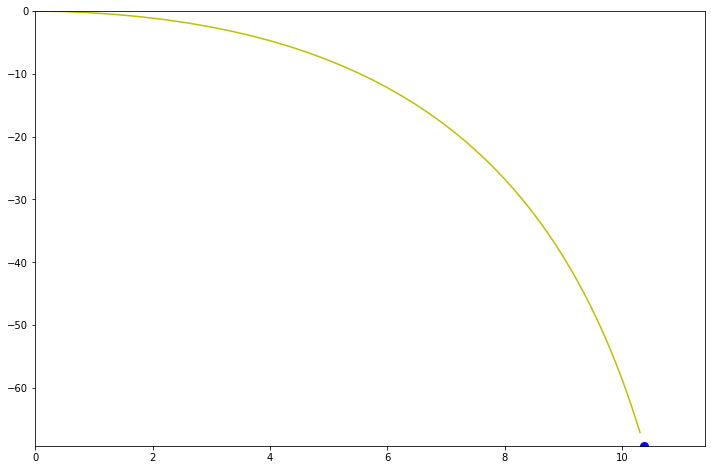

In [4]:
plot_animated(x, y)

In [5]:
# Add noise to measurements
noise_std_x = 0.1
noise_std_y = 0.1
x_noise = x + np.random.normal(scale=noise_std_x, size=N)
y_noise = y + np.random.normal(scale=noise_std_y, size=N)


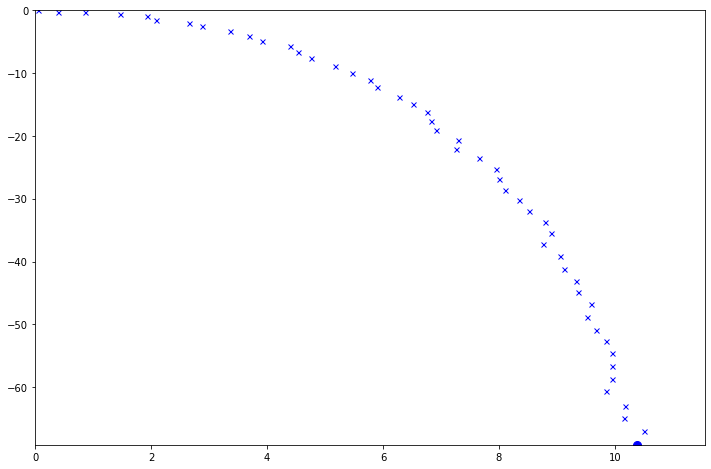

In [6]:
plot_animated(x, y, x_noise, y_noise, show_clean=False)

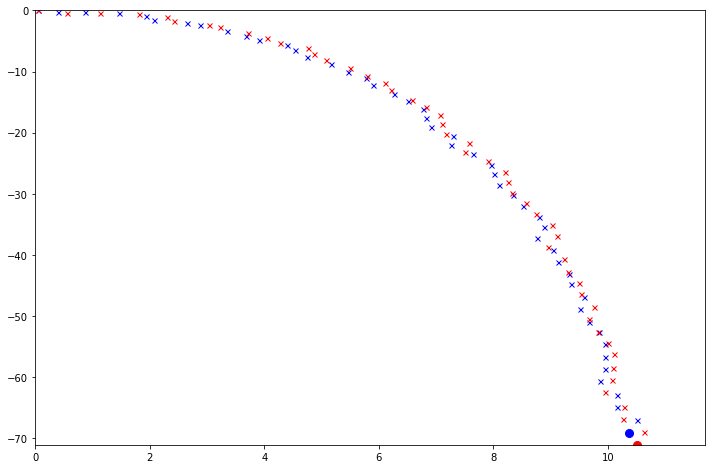

In [8]:
from filterpy.kalman import KalmanFilter

kf = KalmanFilter (dim_x=4, dim_z=2)
kf.x = np.array([0, 0, 0, 0])  # x, y, vx, vy = 0
kf.F = np.array([[1, 0, dt, 0 ],
                 [0, 1,  0, dt],
                 [0, 0,  1, 0 ],
                 [0, 0,  0, 1 ]])
kf.H = np.array([[1, 0, 0, 0],
                 [0, 1, 0, 0]])
kf.R = np.array([[noise_std_x**2, 0],
                 [0, noise_std_y**2]])


# Init. estimation error: very big!
kf.P = 100 * np.eye(4)
kf.Q = 1 * np.eye(4)  # Let's be humble


x_pred = np.zeros((N, 1))
y_pred = np.zeros((N, 1))

# Our noisy sensor readings are in x_noise, y_noise
for t in range(N):
    
    kf.update([x_noise[t], y_noise[t]])
    kf.predict()
    
    x_pred[t, 0] = kf.x[0]
    y_pred[t, 0] = kf.x[1]


# Plot predictions
plot_animated(x, y, x_noise, y_noise, x_pred, y_pred, interval=100, show_clean=False, pred_ahead=0)

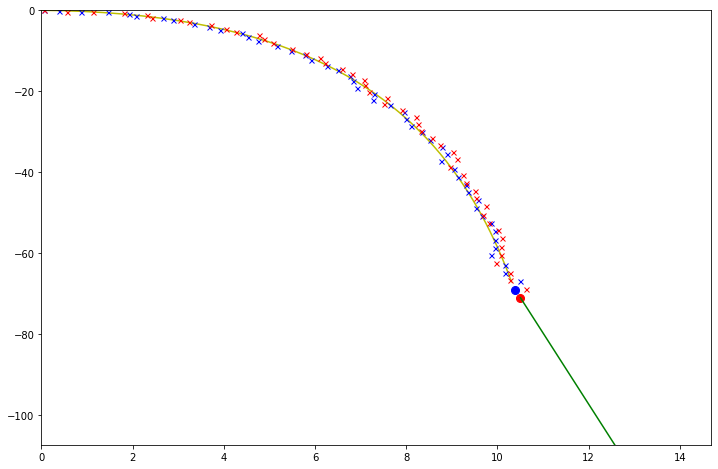

In [12]:
from filterpy.kalman import KalmanFilter
kf = KalmanFilter (dim_x=4, dim_z=2)
kf.x = np.array([0, 0, 0, 0])  # x, y, vx, vy = 0
kf.F = np.array([[1, 0, dt, 0 ],
                 [0, 1,  0, dt],
                 [0, 0,  1, 0 ],
                 [0, 0,  0, 1 ]])
kf.H = np.array([[1, 0, 0, 0],
                 [0, 1, 0, 0]])
kf.R = np.array([[noise_std_x**2, 0],
                 [0, noise_std_y**2]])


# Init. estimation error: very big!
kf.P = 100 * np.eye(4)
kf.Q = 1 * np.eye(4)  # Let's be humble


pred_ahead = 20
x_hist = np.zeros((N, 4))
x_pred = np.zeros((N, pred_ahead))
y_pred = np.zeros((N, pred_ahead))
for t in range(N):
    kf.update([x_noise[t], y_noise[t]])
    kf.predict()
    x_pred[t, 0] = kf.x[0]
    y_pred[t, 0] = kf.x[1]
    
    # Keep history of all state variables
    x_hist[t, :] = kf.x
    
    # Predict ahead several steps
    P_backup = kf.P.copy()
    x_backup = kf.x.copy()
    for i in range(1, pred_ahead):
        kf.predict()
        x_pred[t, i] = kf.x[0]
        y_pred[t, i] = kf.x[1]
    kf.P = P_backup
    kf.x = x_backup


# Plot predictions
plot_animated(x, y, x_noise, y_noise, x_pred, y_pred, interval=100, show_clean=True, pred_ahead=pred_ahead)

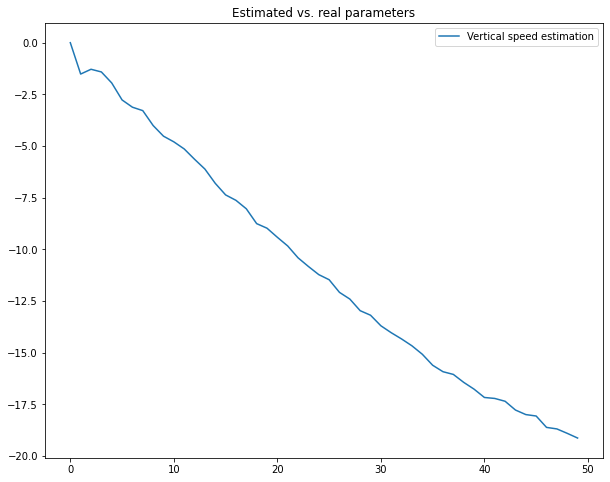

In [13]:
plt.figure(figsize=(10, 8))
plt.plot(x_hist[:, 3], label="Vertical speed estimation")

_ = plt.legend()
_ = plt.title("Estimated vs. real parameters")

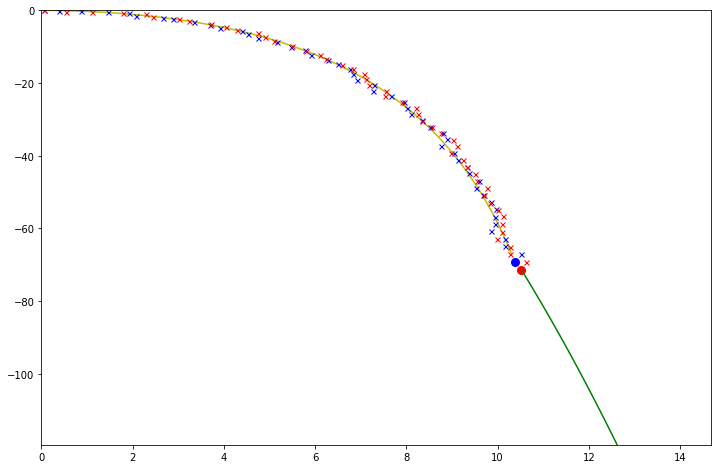

In [14]:
# Filter with 5 state variables: include acceleration

kf = KalmanFilter (dim_x=5, dim_z=2)
kf.x = np.array([0, 0, 0, 0, 0])  # x, y, vx, vy, ay = 0

kf.F = np.array([[1, 0,dt, 0,  0],
                 [0, 1, 0,dt,  0],
                 [0, 0, 1, 0,  0],
                 [0, 0, 0, 1, dt],
                 [0, 0, 0, 0,  1]])

kf.H = np.array([[1, 0, 0, 0, 0],
                 [0, 1, 0, 0, 0]])

kf.P = 10 * np.eye(5)

kf.R = np.array([[noise_std_x**2, 0],
                 [0, noise_std_y**2]])
kf.Q = 0.1 * np.eye(5)

pred_ahead = 20
x_pred = np.zeros((N, pred_ahead))
y_pred = np.zeros((N, pred_ahead))

x_hist = np.zeros((N, 5))
for t in range(N):
    kf.update([x_noise[t], y_noise[t]])
    kf.predict()
    
    x_pred[t] = kf.x[0]
    y_pred[t] = kf.x[1]
    
    # Keep history of all state variables
    x_hist[t, :] = kf.x
    
    # Predict ahead several steps
    P_backup = kf.P.copy()
    x_backup = kf.x.copy()
    for i in range(1, pred_ahead):
        kf.predict()
        x_pred[t, i] = kf.x[0]
        y_pred[t, i] = kf.x[1]
    kf.P = P_backup
    kf.x = x_backup

    
# Plot predictions
plot_animated(x, y, x_noise, y_noise, x_pred, y_pred, interval=100, pred_ahead=pred_ahead)

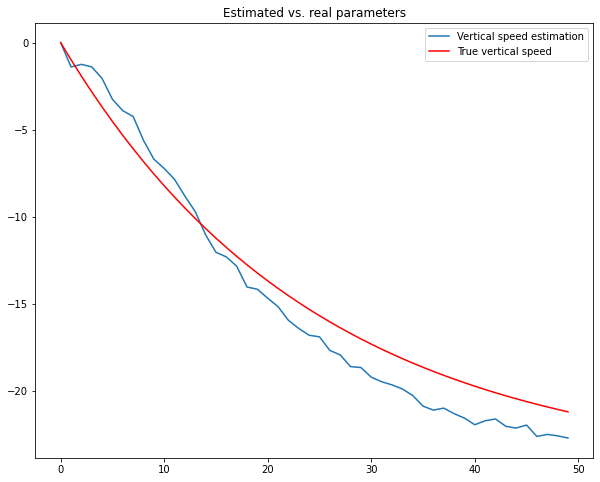

In [15]:
plt.figure(figsize=(10, 8))
plt.plot(x_hist[:, 3], label="Vertical speed estimation")
plt.plot(vy, color='r', label="True vertical speed")

_ = plt.legend()
_ = plt.title("Estimated vs. real parameters")

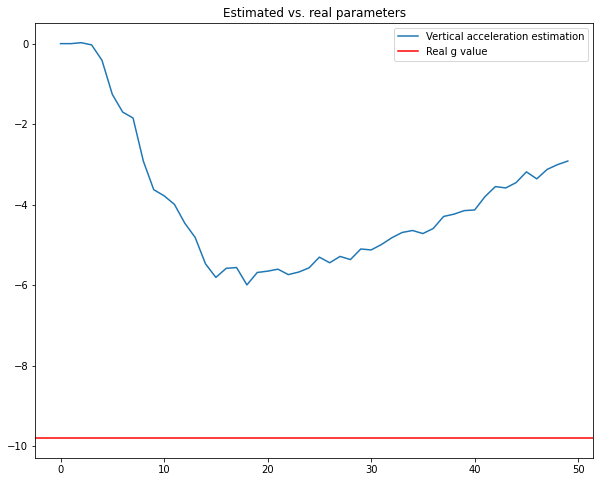

In [16]:
plt.figure(figsize=(10, 8))
plt.plot(x_hist[:, 4], label="Vertical acceleration estimation")
plt.axhline(g, color='r', label="Real g value")

_ = plt.legend()
_ = plt.title("Estimated vs. real parameters")

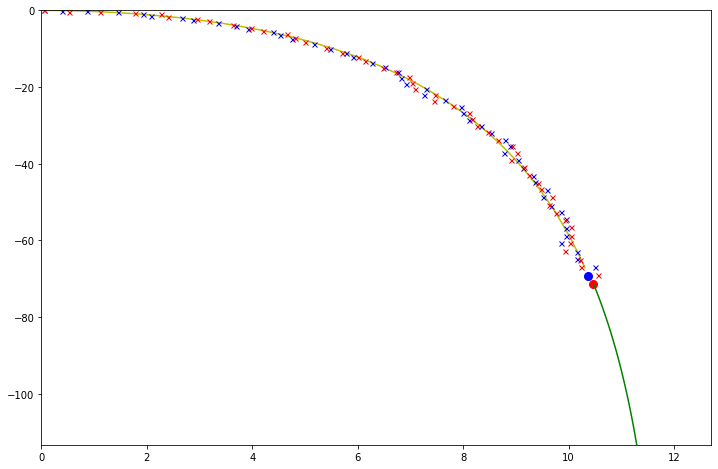

In [21]:

kf = KalmanFilter (dim_x=7, dim_z=2)
kf.x = np.array([0, 0, 0, 0, 0, 0, 0])  # x, y, vx, vy, ax, ay, g = 0

# Can't include b as part of the vector state as the eq. would be non-linear
kf.F = np.array([[1, 0, dt,  0,  0,  0, 0 ],
                 [0, 1,  0, dt,  0,  0, 0 ],
                 [0, 0,  1,  0, dt,  0, 0 ],
                 [0, 0,  0,  1,  0, dt, 0 ],
                 [0, 0, -b,  0,  0,  0, 0 ],
                 [0, 0,  0, -b,  0, 0,  1 ],
                 [0, 0,  0,  0,  0, 0,  1 ]])

kf.H = np.array([[1, 0, 0, 0, 0, 0, 0],
                 [0, 1, 0, 0, 0, 0, 0]])

kf.P = 10 * np.eye(7)

kf.R = np.array([[noise_std_x**2, 0],
                 [0, noise_std_y**2]])
kf.Q = 0.1 * np.eye(7)

pred_ahead = 20
x_pred = np.zeros((N, pred_ahead))
y_pred = np.zeros((N, pred_ahead))

x_hist = np.zeros((N, 7))
for t in range(N):
    kf.update([x_noise[t], y_noise[t]])
    kf.predict()
    
    x_pred[t] = kf.x[0]
    y_pred[t] = kf.x[1]
    
    # Keep history of all state variables
    x_hist[t, :] = kf.x
    
    # Predict ahead several steps
    P_backup = kf.P.copy()
    x_backup = kf.x.copy()
    for i in range(1, pred_ahead):
        kf.predict()
        x_pred[t, i] = kf.x[0]
        y_pred[t, i] = kf.x[1]
    kf.P = P_backup
    kf.x = x_backup

    
# Plot predictions
plot_animated(x, y, x_noise, y_noise, x_pred, y_pred, interval=100, pred_ahead=pred_ahead)

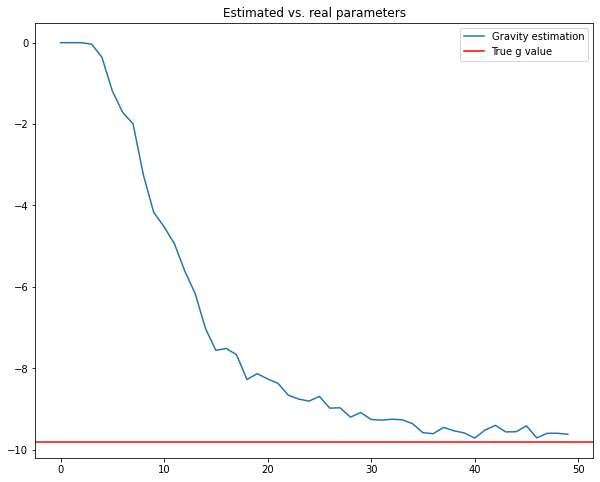

In [18]:
plt.figure(figsize=(10, 8))
plt.plot(x_hist[:, 6], label="Gravity estimation")
plt.axhline(g, color='r', label="True g value")

_ = plt.legend()
_ = plt.title("Estimated vs. real parameters")